In [2]:
!pip install segmentation_models_pytorch 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 KB 334.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 1.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 KB 1.0 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=6a941f8e85156823f182b22ce660983d825d6084d4ca6ad1b79d931e61c0a929
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=d51ebec3c84bfb04986973f6431805b581869e6d4130c21f6e453db7be7a068a
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [50]:
import numpy as np
import pandas as pd
from PIL import Image
import random

import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import cv2
# import torch_optimizer as optim

import warnings
import os
import gc
import glob
import os.path as osp


PATH='../input/airbus-224x224x3/train_v2'
PATH_TRAIN='../input/airbus-224x224x3/train_v2'
PATH_TEST='../input/airbus-224x224x3/test_v2'

warnings.filterwarnings('ignore')
%matplotlib inline

# Albumentations


In [26]:
# https://github.com/albu/albumentations
from albumentations import (ToFloat, 
    CLAHE, RandomRotate90, Transpose, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, OneOf, Compose,HorizontalFlip,VerticalFlip
)

In [27]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


 # Ship Detection: Image Visualizations and short EDA

## Loading the Datasets

In [28]:
class AirbusDS(Dataset):
    """
    A customized data loader.
    """
    def __init__(self, root):
        """ Intialize the dataset
        """
        self.filenames = []
        self.root = root
        self.transform = transforms.ToTensor()
        filenames = glob.glob(osp.join(PATH, '*.jpg'))
        for fn in filenames:
            self.filenames.append(fn)
        self.len = len(self.filenames)
        
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """ 
        image = Image.open(self.filenames[index])
        return self.transform(image)

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

## Show data 

192556


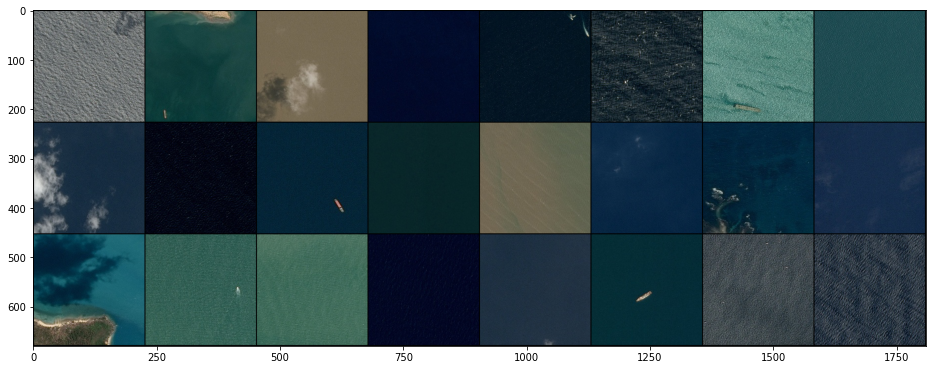

In [29]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
air_img = AirbusDS(PATH)
print(air_img.len)
# Use the torch dataloader to iterate through the dataset
loader = DataLoader(air_img, batch_size=24, shuffle=False, num_workers=0)

# get some images
dataiter = iter(loader)
images = dataiter.next()

# show images
plt.figure(figsize=(16,8))
imshow(torchvision.utils.make_grid(images))

## Masks & Albumentations class

In [30]:
masks = pd.read_csv('../input/airbus-224x224x3/train_ship_segmentations_v2.csv')

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768),resize=False):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape).T
    if resize:
        img = cv2.resize(img, (224, 224), cv2.INTER_AREA)
    return img  

masks.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [31]:
# an improve
mean = np.array([0.65459856,0.48386562,0.69428385])
std = np.array([0.15167958,0.23584107,0.13146145])
def img2tensor(img, dtype:np.dtype=np.float32):
    if img.ndim==2: 
        img=np.expand_dims(img, 2)
    return torch.from_numpy(img.astype(dtype, copy=False))

class AirbusDS(Dataset):
    """
    A customized data loader.
    """
    def __init__(self, root, aug = False, mode='train'):
        """ Intialize the dataset
        """
        self.filenames = []
        self.root = root
        self.aug = aug
        self.mode = 'test'
        if mode == 'train':
            self.mode = 'train'
            self.masks = pd.read_csv('../input/airbus-224x224x3/train_ship_segmentations_v2.csv').fillna(-1)
        if self.aug:
            self.transform = OneOf([
                                RandomRotate90(),
                                Transpose(),
                                Flip(),
                            ], p=0.3)
        else:
            self.transform = transforms.ToTensor()
        filenames = glob.glob(osp.join(PATH, '*.jpg'))
        for fn in filenames:
            self.filenames.append(fn)
        self.len = len(self.filenames)
        
    # You must override __getitem__ and __len__
    def get_mask(self, ImageId):
        img_masks = self.masks.loc[self.masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

        # Take the individual ship masks and create a single mask array for all ships
        all_masks = np.zeros((768, 768))
        if img_masks == [-1]:
            return all_masks
        for mask in img_masks:
            all_masks += rle_decode(mask)
        return all_masks
    
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        image = Image.open(self.filenames[index])
        ImageId = self.filenames[index].split('/')[-1]
        if self.mode == 'train':
            mask = self.get_mask(ImageId)
        if self.aug:
            if self.mode == 'train':
                data = {"image": np.array(image), "mask": mask}
            else:
                data = {"image": np.array(image)}
            transformed = self.transform(**data)
            image = transformed['image']/255
            image = np.transpose(image, (2, 0, 1))
            if self.mode == 'train':
                return img2tensor(image), img2tensor(transformed['mask'][np.newaxis,:,:] )
            else:
                return img2tensor(image)
        else:
            if self.mode == 'train':
                return self.transform(img2tensor(image)),img2tensor( mask[np.newaxis,:,:] )
            return self.transform(img2tensor(image))

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len
 
 


## Data Loader 

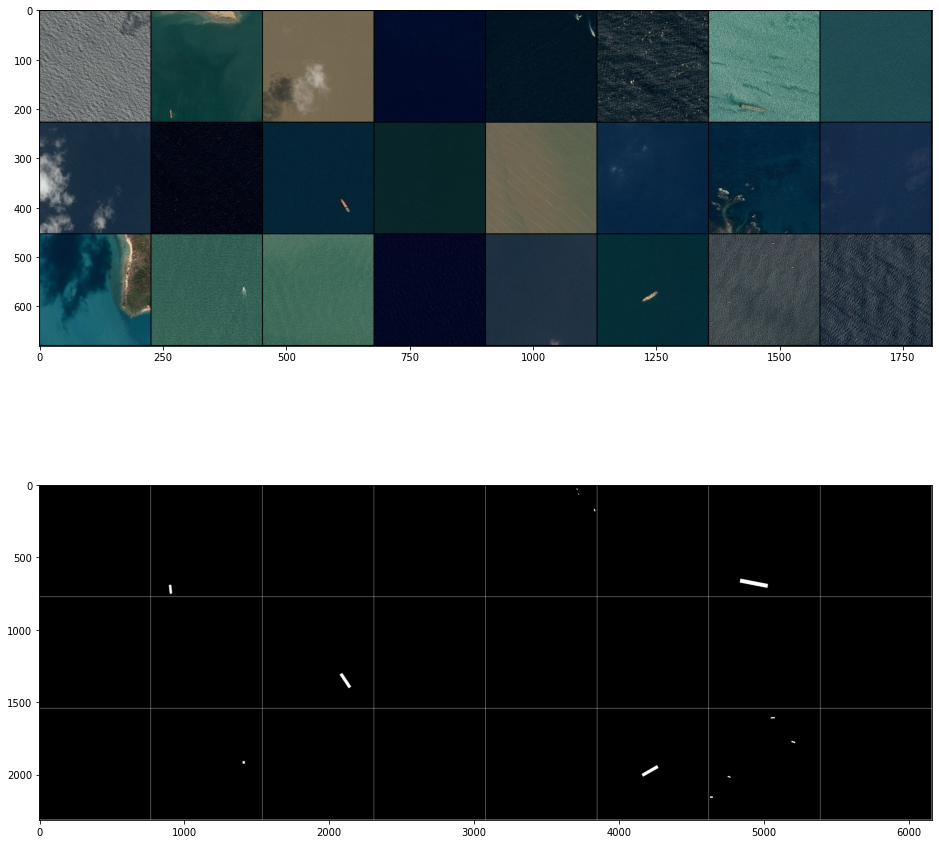

In [32]:
airimg = AirbusDS(PATH, aug=True, mode='train')
# Use the torch dataloader to iterate through the dataset
loader = DataLoader(airimg, batch_size=24, shuffle=False, num_workers=0)

# get some images
dataiter = iter(loader)
images, masks = dataiter.next()

# show images
plt.figure(figsize=(16,16))
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(211)
imshow(torchvision.utils.make_grid(images))
plt.subplot(212)
imshow(torchvision.utils.make_grid(masks,pad_value=25.0))


# Preparations before training
<img src="https://memegenerator.net/img/instances/86276885.jpg" >


## transform

In [33]:
train_transforms = Compose([transforms.Resize(512),
                           Flip(), RandomRotate90(),
                           HorizontalFlip(),
                           VerticalFlip(),
                           transforms.RandomCrop(512)]
                           )

## Split, Dataset & DataLoader

In [61]:
# Take the individual ship masks and create a single mask array for all ships
def mask_as_image(masks, resize=True):
    possible_masks = np.zeros((224, 224))
    for mask in masks:
        if isinstance (mask,float):
            break
        else:
            mask_image = rle_decode(mask, resize=True)
            if resize:
                mask_image = cv2.resize(mask_image, (224, 224), cv2.INTER_AREA)
            possible_masks += mask_image
    return possible_masks

# source='https://www.kaggle.com/inversion/run-length-decoding-quick-start'
def show_image_with_mask(imgs, masks,rows,cols):
    fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
#     imgs = cv2.resize(imgs, (224, 224), cv2.INTER_AREA)
#     plt.figure(figsize=[cols*5, rows*5])
    for i in range(len(imgs)):
        img = imgs[i]
        mask = masks[i]
        img = img.numpy()
        mask = mask.numpy()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axarr[0].axis('off')
        axarr[0].imshow(img)
        
        axarr[1].axis('off')
        axarr[1].imshow(mask)
        
        axarr[2].axis('off')
        axarr[2].imshow(img)
        axarr[2].imshow(mask, alpha=0.8)
        plt.tight_layout(h_pad=0.1, w_pad=0.1)
        plt.show()    
    
# Dataset class adapted to train, validation and test situations
class shipDataset(Dataset):
    def __init__(self,paths, transforms=None, train= True, test=False, mask_file=None):
        self.paths = paths
        self.transforms = transforms
        self.train = train
        self.mask_file = mask_file
        self.test=test  
        self.permute = False
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p= self.paths[idx]
        imageId=p.split('/')[-1]
        image = cv2.imread(p)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.normalize(image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
        if self.train:
            mask_list=self.mask_file.loc[self.mask_file["ImageId"]==imageId, "EncodedPixels"].tolist()
            masks = mask_as_image(mask_list, resize=True)
            if self.transforms:

                image = self.transforms(image=image)['image']
                masks = self.transforms(masks)['mask']
            
            masks = torch.from_numpy(masks).float()
        image = torch.from_numpy(image).float()
        

        #swap [768, 768, 3]---TO---> [3,768, 768]
        if self.permute:
            image = image.permute(2, 0,1)
        if self.test:
            return image, imageId

        else:
            return image, masks  
        
def get_train (paths, next_path, csv, base_path, ship=True):
    csv_mask = csv.copy()
    new_lst = []
    if ship:
        df = csv_mask[csv_mask["EncodedPixels"].notna()].copy()
    else:
        df = csv_mask[csv_mask["EncodedPixels"].isna()].copy()
    df = df.drop_duplicates(subset="ImageId")
    for rows in (df.iterrows()):
        new_lst.append(base_path+next_path+"/"+rows[1].ImageId)
    return new_lst

filenames_train = glob.glob(osp.join(PATH_TRAIN, '*.jpg'))
test_paths = glob.glob(osp.join(PATH_TEST, '*.jpg'))
mask_file = pd.read_csv('../input/airbus-224x224x3/train_ship_segmentations_v2.csv')

# reduce train size 
base_path = "../input/airbus-224x224x3/"
train_ship = get_train(filenames_train, "train_v2", mask_file, base_path, True)
train_na_ship = get_train(filenames_train, "train_v2", mask_file, base_path, False)
print(f'len(images with shipe) = {len(train_ship)}\nlen(images without shipe) = {len(train_na_ship)}')
# reduce size of train without ships
train_na_ship = random.sample(train_na_ship, int(len(train_na_ship)*0.01))
train_ship = random.sample(train_ship, int(len(train_ship)*0.05))
filenames_train = train_na_ship + train_ship
print(f'len(data) = {len(filenames_train)}')
#split
train_paths, validation_paths = train_test_split(filenames_train, test_size=0.3,random_state=42)
print(f'len(test)/[len(test)+len(train)] = len(validation)/[len(validation)+len(train)]')
print(f'{len(test_paths)/(len(test_paths)+len(filenames_train))} = {len(validation_paths)/(len(validation_paths)+len(train_paths))}')
csv_mask_file = pd.read_csv('../input/airbus-224x224x3/train_ship_segmentations_v2.csv').fillna(-1)
# DataSet

train_dataset = shipDataset(train_paths, transforms=False, train=True, mask_file=mask_file)
valid_dataset = shipDataset(validation_paths, train=True,mask_file=mask_file)
test_dataset = shipDataset(test_paths, train=False, test=True)

# DataLoader
BS=24
NW=0
train_loader= DataLoader(train_dataset,batch_size=BS,shuffle=False) #, shuffle = False)#, pin_memory=True)
valid_loader= DataLoader(valid_dataset,batch_size=BS,shuffle=False) #, num_workers=NW)#, pin_memory=True)
test_loader= DataLoader(test_dataset,batch_size=1,shuffle=False)#, num_workers=NW)#, pin_memory=True)

len(images with shipe) = 42556
len(images without shipe) = 150000
len(data) = 3627
len(test)/[len(test)+len(train)] = len(validation)/[len(validation)+len(train)]
0.811417875526439 = 0.3002481389578164


## Images & Masks

0it [00:00, ?it/s]

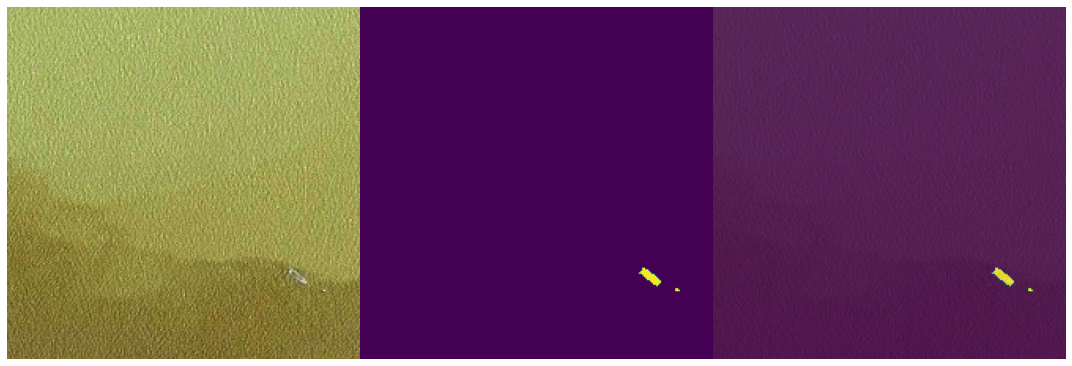

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

1it [00:01,  1.57s/it]

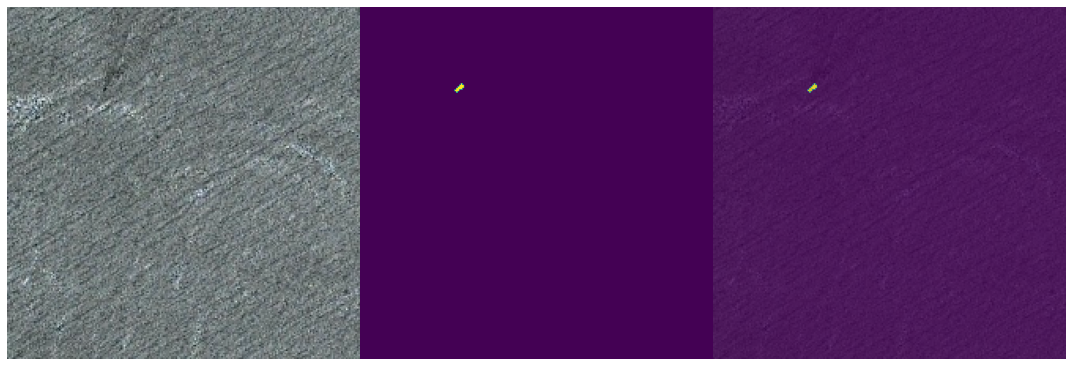

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

2it [00:03,  1.55s/it]

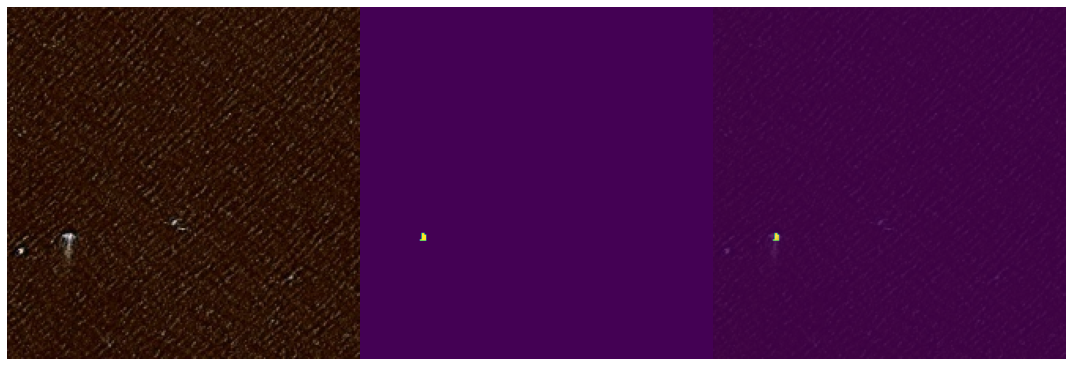

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

3it [00:04,  1.59s/it]

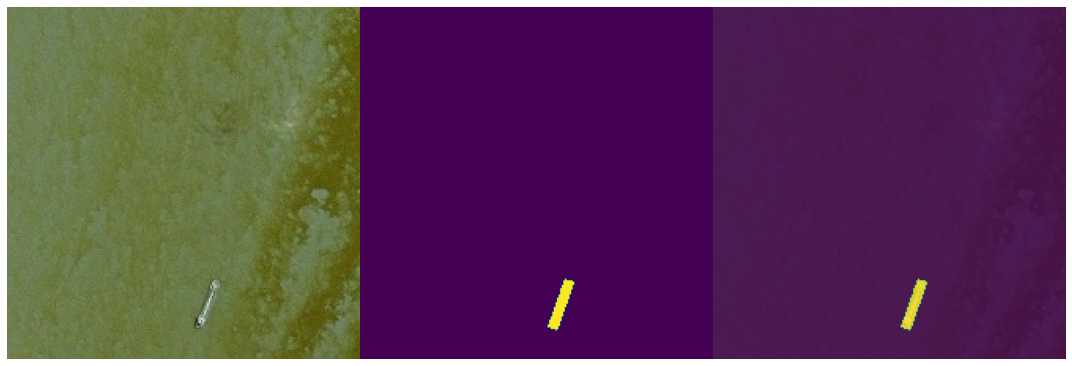

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

4it [00:06,  1.62s/it]

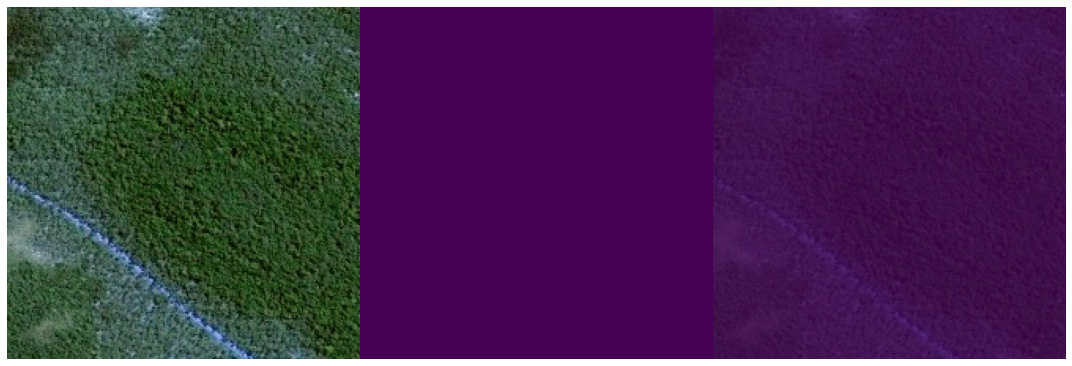

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

5it [00:09,  1.81s/it]


In [35]:
for i,(image, masks) in tqdm(enumerate(train_loader)):
    if i < 5:
        show_image_with_mask(image[0:3], masks[0:3],4,4)    
    else:
        break
    

* As we can see- there are images without ships. I will address the issue later.

In [36]:
del airimg
del loader
del dataiter
del images
del train_na_ship
del filenames_train

gc.collect()

123076

# Model training APIs

In [62]:
NUM_EPOCHS = 3
def get_train_and_valid_epochs(model, loss, metrics, optimizer):
    train_epoch = smp.utils.train.TrainEpoch(
        model,
        loss=loss,
        metrics=metrics,
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model,
        loss=loss,
        metrics=metrics,
        device=DEVICE,
        verbose=True,
    )

    return train_epoch, valid_epoch

def get_test_epochs(model, loss, metrics):
    test_epoch = smp.utils.train.ValidEpoch(
        model,
        loss=loss,
        metrics=metrics,
        device=DEVICE,
    )
    
    return test_epoch

def train(model, loss, metrics, optimizer, train_loader, valid_loader, model_name):
    max_score = 0
    train_epoch, valid_epoch = get_train_and_valid_epochs(model, loss, metrics, optimizer)
    df = pd.DataFrame(columns=['train_loss','train_iou','val_loss','val_iou' ])
    for i in range(0, NUM_EPOCHS):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        
        df = df.append({'train_loss':train_logs['dice_loss'],'train_iou':train_logs['iou_score'],
                        'val_loss':valid_logs['dice_loss'],'val_iou':valid_logs['iou_score']},ignore_index=True)

        # do something (save model, change lr, etc.)
        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, f'./{model_name}_best_model.pth')
            print('Model saved!')
    df.to_csv(f'{model_name}.csv', index=False)
    return df

## Dice Loss
* Dice coefficient-  
![picture](https://miro.medium.com/max/321/1*EF3VCtk-VbTIKhriaQF0YQ.png)
*  measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap. The Dice coefficient was originally developed for binary data, and can be calculated as:  
$ Dice = \frac{2|A∩B|}{|A|+|B|} $
  * |A∩B| represents the common elements between sets A and B
  * |A| represents the number of elements in set A (and likewise for set B)

For the case of evaluating a Dice coefficient on predicted segmentation masks, we can approximate |A∩B| as the element-wise multiplication between the prediction and target mask, and then sum the resulting matrix.

In [38]:
dice_loss = smp.utils.losses.DiceLoss()
dice_loss.to(DEVICE)

DiceLoss(
  (activation): Activation(
    (activation): Identity()
  )
)

## IOU – Intersection over union measure
<img src = 'https://www.researchgate.net/profile/Swapnil-Bhole/publication/340893451/figure/fig2/AS:921669640126464@1596754574959/Intersection-over-Union-IoU.ppm'
     height = 550px width=550px>

In [39]:
metrics = [
    smp.utils.metrics.IoU(threshold=0.5).to(DEVICE),
]


# Architecture training
* U-NET
* FPN
* PAN
* DeepLabV3

In [63]:
train_loader.dataset.permute = True
valid_loader.dataset.permute = True

ENCODER_RESNET='resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['airbus']
ACTIVATION = 'sigmoid'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_model(model, model_name):
    model.cuda()
    optimizer= torch.optim.Adam(model.parameters(),lr= 1e-3)
    model_name=model_name

    return train(model, dice_loss, metrics, optimizer, train_loader, valid_loader, model_name)

## U-net segmentation architecture 
* Its shape is that it uses special architecture to create very few data set segments. 
* The layers he uses: 
    * convolution-layers
    * pooling-layers
    * up-convolution-layers (sometimes)
    * up-convolution-layers: Take each neuron in the input in the layer, and create a neuron of size 2 * 2 (the opposite of polling)
    
<img src ="https://pyimagesearch.com/wp-content/uploads/2021/11/u-net_training_image_segmentation_models_in_pytorch_header.png">

In [64]:
unet = smp.Unet(
    encoder_name=ENCODER_RESNET,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
unet = unet.to(DEVICE) 
run_model(unet, 'U-Net')  
gc.collect()
torch.cuda.empty_cache() 


Epoch: 0
valid: 100%|██████████| 46/46 [00:50<00:00,  1.11s/it, dice_loss - 0.8403, iou_score - 0.09196]
Model saved!

Epoch: 1
valid: 100%|██████████| 46/46 [00:41<00:00,  1.11it/s, dice_loss - 0.6737, iou_score - 0.2107]
Model saved!

Epoch: 2
valid: 100%|██████████| 46/46 [00:42<00:00,  1.09it/s, dice_loss - 0.5184, iou_score - 0.3384]
Model saved!


## FPN (Feature Pyramid Network) segmentation architecture 
* It combines low-resolution, semantically strong features with high-resolution, semantically weak features via a top-down pathway and lateral connections. 
* FPN provides a top-down pathway to construct higher resolution layers from a semantic rich layer.

<img src ="https://miro.medium.com/max/1380/1*D_EAjMnlR9v4LqHhEYZJLg.png" height=500px width = 500px>

In [19]:
fpn = smp.FPN(
    encoder_name=ENCODER_RESNET,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
fpn = fpn.to(DEVICE)
run_model(fpn, 'FPN')
gc.collect()
torch.cuda.empty_cache()


Epoch: 0
valid: 100%|██████████| 46/46 [00:53<00:00,  1.16s/it, dice_loss - 0.8424, iou_score - 0.08942]
Model saved!

Epoch: 1
valid: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s, dice_loss - 0.5202, iou_score - 0.3361]
Model saved!

Epoch: 2
valid: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s, dice_loss - 0.4262, iou_score - 0.4238]
Model saved!


## PAN Pyramid Attention Network for Semantic Segmentation (Semantic Segmentation)
* Network Architecture:     

<img src ="https://miro.medium.com/max/1400/1*3_WEElD7UeCGpf2R504Rtg.png" >

* Feature Pyramid Attention (FPA) Module: 
    * FPA fuses features from under three different pyramid scales by implementing a U-shape structure like Feature Pyramid Network (FPN).  
    
* Global Attention Upsample (GAU) Module:  
    * GAU deploys different scale feature maps more effectively and uses high-level features provide guidance information to low-level feature maps in a simple way. 

In [65]:
pan = smp.PAN(
    encoder_name=ENCODER_RESNET,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
pan = pan.to(DEVICE)
run_model(pan, 'PAN')
gc.collect()
torch.cuda.empty_cache()


Epoch: 0
valid: 100%|██████████| 46/46 [00:41<00:00,  1.10it/s, dice_loss - 0.3894, iou_score - 0.4775]
Model saved!

Epoch: 1
valid: 100%|██████████| 46/46 [00:41<00:00,  1.10it/s, dice_loss - 0.411, iou_score - 0.4533] 

Epoch: 2
valid: 100%|██████████| 46/46 [00:41<00:00,  1.11it/s, dice_loss - 0.3677, iou_score - 0.4971]
Model saved!


## DeepLabV3
* The DeepLabV3 model has the following architecture:
    * Features are extracted from the backbone network (VGG, DenseNet, ResNet).
    * To control the size of the feature map, atrous convolution is used in the last few blocks of the backbone.
    * On top of extracted features from the backbone, an ASPP network is added to classify each pixel corresponding to their classes.
    * The output from the ASPP network is passed through a 1 x 1 convolution to get the actual size of the image which will be the final segmented mask for the image.
    <img src ="https://gaussian37.github.io/assets/img/vision/segmentation/deeplabv3/0.png" >  
    
 [More about Atrous Convoltion (Dilated Convolution)](https://developers.arcgis.com/python/guide/how-deeplabv3-works/)

In [41]:
deep = smp.DeepLabV3(
    encoder_name=ENCODER_RESNET,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
deep = deep.to(DEVICE)
run_model(deep, 'DEEP')
gc.collect()
torch.cuda.empty_cache() 




Epoch: 0
valid: 100%|██████████| 46/46 [00:56<00:00,  1.22s/it, dice_loss - 0.8605, iou_score - 0.07684]
Model saved!

Epoch: 1
valid: 100%|██████████| 46/46 [00:46<00:00,  1.02s/it, dice_loss - 0.649, iou_score - 0.225]  
Model saved!

Epoch: 2
valid: 100%|██████████| 46/46 [00:46<00:00,  1.02s/it, dice_loss - 0.5106, iou_score - 0.3402]
Model saved!


# Evaluation of training results - model selection

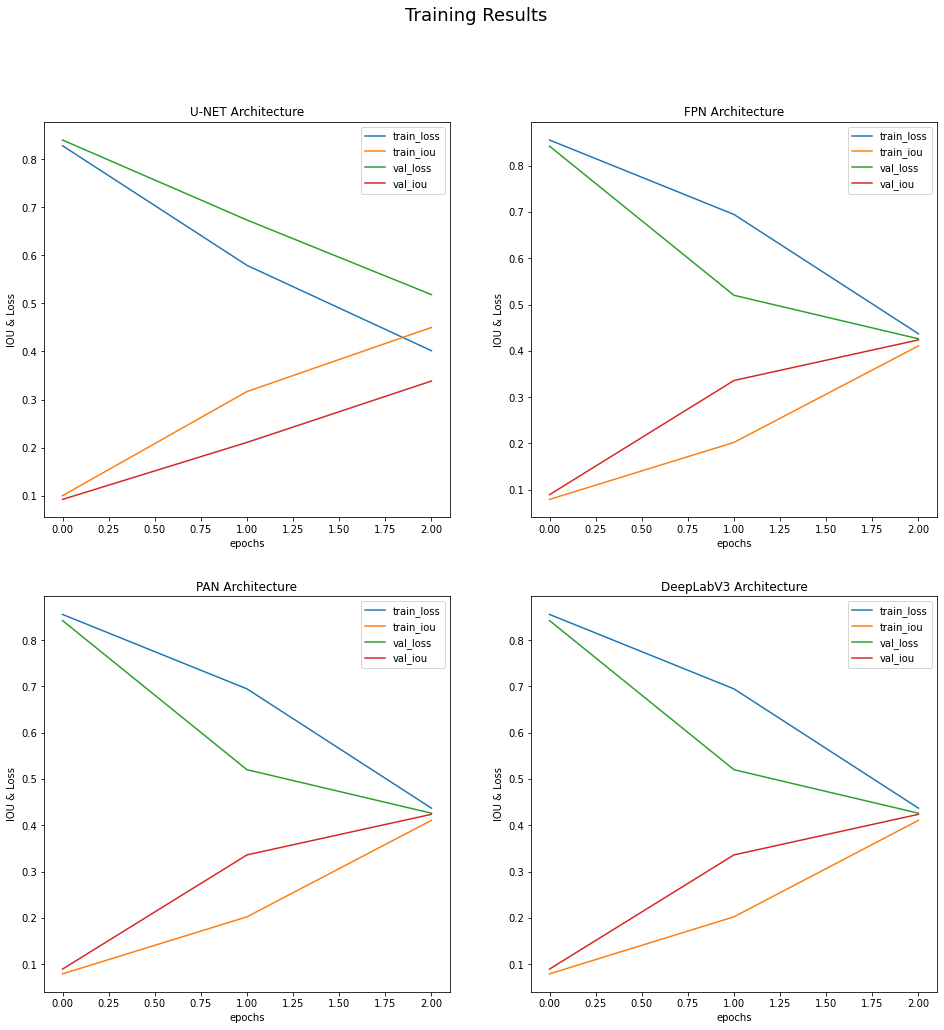

In [66]:
unet_results_df = pd.read_csv("U-Net.csv") 
fpn_results_df = pd.read_csv("FPN.csv") 
pan_results_df = pd.read_csv("PAN.csv") 
deep_results_df = pd.read_csv("DEEP.csv") 

fig, axis = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle(f"Training Results", fontsize = 18)
columns = 2
rows = 2

# UNET
unet_results_df.plot(title="U-NET Architecture",ax=axis[0, 0])
axis[0, 0].set_xlabel("epochs")
axis[0, 0].set_ylabel('IOU & Loss') 


# FPN
fpn_results_df.plot(title="FPN Architecture",ax=axis[0, 1])
axis[0, 1].set_xlabel("epochs")
axis[0, 1].set_ylabel('IOU & Loss') 


# PAN
fpn_results_df.plot(title="PAN Architecture", ax= axis[1, 0])
axis[1, 0].set_xlabel("epochs")
axis[1, 0].set_ylabel('IOU & Loss') 



# DEEP
fpn_results_df.plot(title="DeepLabV3 Architecture", ax=axis[1, 1])
axis[1, 1].set_xlabel("epochs")
axis[1, 1].set_ylabel('IOU & Loss') 

plt.show()

# Show Results

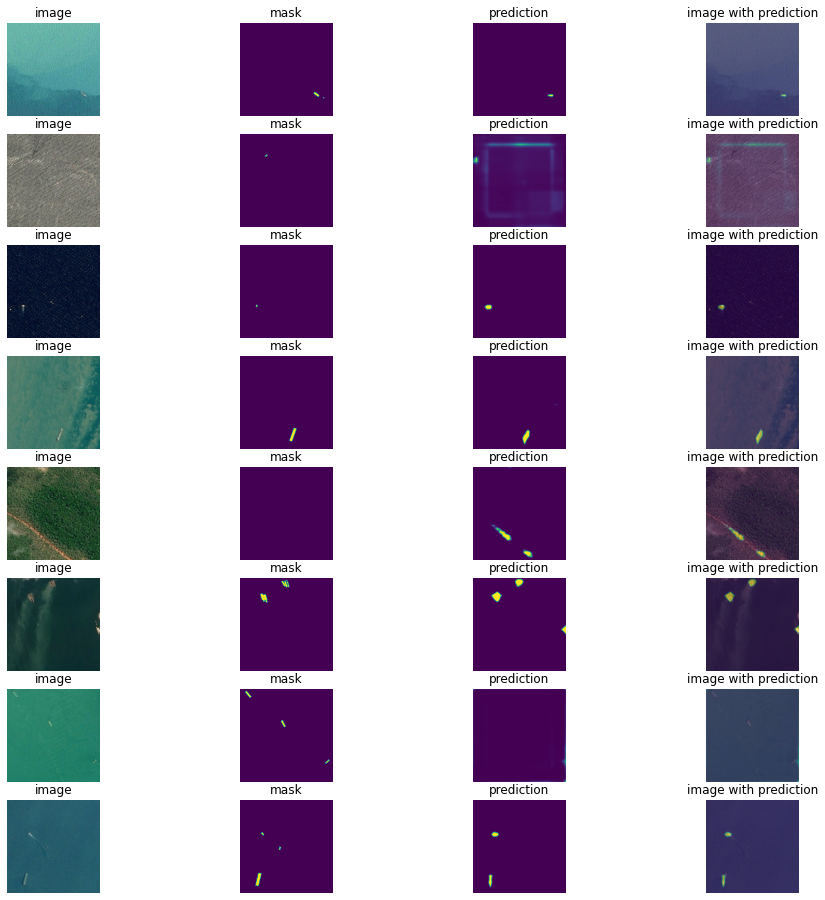

In [42]:
def show_results(model, loader, num_of_rows=16):
    fig, ax = plt.subplots(num_of_rows, 4,figsize=(16,16))
    row = 0
    model = model.cpu()
    for image, mask in loader:
#         image = image.cpu().permute(0, 3, 1, 2)
        pred = model(image)
        image = image.cpu().permute(0, 2, 3, 1).detach().numpy()[0]
        mask = mask.cpu().detach()[0].numpy()
        pred = pred.detach()[0][0].cpu().numpy()
        ax[row][0].imshow(image)
        ax[row][1].imshow(mask)
        ax[row][2].imshow(pred)
        ax[row][3].imshow(image)
        ax[row][3].imshow(pred, alpha=0.5)
        for j in range(4):
            ax[row][j].axis('off')
        ax[row][0].set_title('image')
        ax[row][1].set_title('mask')
        ax[row][2].set_title('prediction')
        ax[row][3].set_title('image with prediction')
        row += 1
        if row == num_of_rows:
            break
    plt.show()
    
best_model_path="./DEEP_best_model.pth"
model = torch.load(best_model_path)

show_results(model, train_loader, num_of_rows=8)

# Model test APIs

In [52]:
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = np.float64(img.T.flatten()) 
    pixels = np.around(pixels, decimals=2)
    idx = 0
    res = []
    counts = []
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1] )[0]
    zeros_loc = np.where(np.append(pixels[runs],0.0) == 0.0)[0]
    counts = zeros_loc[1::] - zeros_loc[:len(zeros_loc)-1:]
    for i in counts:
        res.append(runs[idx])
        res.append(i)
        idx = idx + i
    return res

# Submit 

In [53]:
itr = iter(test_loader)
out_pred_rows = []
model.eval()
count=0
fig = plt.figure(figsize=(8,8))
for i in range(len(itr)):
    # current version without real submission
#     if i > 3:   
#         break 
    x, imgid = next(itr)
    imgid = imgid[0]
    model.to('cuda') 
    x = x.permute(0,3,1,2)  
    y = model(x.to('cuda'))
    y = y.cpu().detach().numpy().squeeze()
  
    c_rle = rle_encode(y)
    out_pred_rows += [{'ImageId': imgid, 'EncodedPixels': ' '.join(str(x) for x in c_rle)}]
                                    
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]   
submission_df.to_csv('submission.csv', index=False)  

100%|██████████| 15606/15606 [1:44:34<00:00,  2.49it/s]


<Figure size 576x576 with 0 Axes>

In [69]:
submission_df = submission_df.replace(r'^\s*$', np.nan, regex=True).reset_index(drop=True)
submission_df = submission_df.sort_values(by="ImageId", ascending=True)
submission_df.to_csv('submission.csv', index=False)    

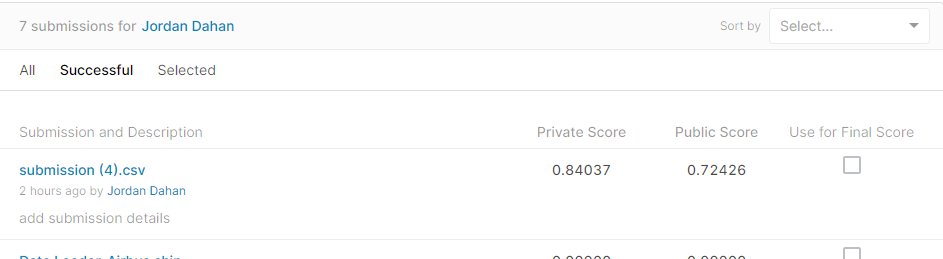

In [80]:
submission_df.sample(2)

ImageId                                      EncodedPixels
5706  33c749b3a.jpg                                                NaN
5424  7ffcbe360.jpg  31234 2 31457 6 31680 8 31903 10 32126 12 3234...

# TL;DR

* First we created basic `AirbusDS` class for dataset- with no augmentaions nor masks.
* Then using `https://www.kaggle.com/paulorzp/run-length-encode-and-decode` ww've got rle decode function for adding masks on the dataset.
* After that we implemented `AirbusDS` class with albumentations and masks
* Finally we use the dataloader to iterate and present sample of images and the segmentations.

## work process
* After the first attempt of training the UNET model, the running time took too long, so after searching I found a reduced Dataset for the competition - thanks to Ofri Harel.
    * The model training time with the reduced data was significantly improved.
* Much of the notebook here is taken from the smp documentation examples, see link in references.

1. At the beginning of the notebook I experimented a bit with masks, rle_encode.
2. In order to train the models, I made preparations - I used transformations and augmentations that do not deal with image blurring.
    * After looking at the data I saw that there are many pictures without boats - for example pictures of buildings (and not in the open sea). Therefore, I reduced the amount of pictures without the boats in order to create a little proportion in the data and also to reduce training times and prevent the notebook from collapsing. Running time after this reduction decreased from an hour or more to a few minutes.
3. I divided the data into 3 groups: valid train, test based on the paths of the images and masks and thus I avoided saving them in the dataframe . I made sure that the ratio between train, validation would be the same as the total train data per test.
    * I created a dataLoader for each group.

4. Before insert the data into the model for training, I updated the dataset department, since a permute must be made for the images in the models - the support is for the dimensions [channels, height, width], so I made sure to swipe the dimensions.
5. Using trainningAPI I trained the models when after each workout I made sure to clear the cache to avoid CUDA OUT OF MEMORY and notebook crash. I also additionally saved the model results in csv. In order to then load the results and plot on them and thus choose the best model.

6. In the test phase I had to encode the image - the algorithm inspired by other notebooks I saw here, but I had to change it for this notebook:
    * rle_encode:    
        * First, if the whole image is zero, it means that there are no pixels whose value is close to 1.0. We will return an empty encoding.
        * I convert the prediction to np.float64 to 2 digits after the dot.
        * I am looking for the areas where the image is not symmetrical (the areas where we hopefully predicted correctly that the ships are)
        * I take out the positions of the zeros in the image I took care to chain between pixels
        * I create a set of counters that counts the number of pixels (number of members) between the zeros.
        * Then I extract each time the initial pixel and the corresponding counter does not.
    And that's it.
    
* Note: for better results- 
    1. train on more data -  I reduced the amount of data because of the runtime (more data means about 20 minutes per epoch) in this notebook one epoch ran at 3 minutes.
    2. Increase NUM_EPOCHS

## References

* https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb
* https://www.kaggle.com/code/alexj21/pytorch-eda-unet-from-scratch-finetuninghttps://www.kaggle.com/code/alexj21/pytorch-eda-unet-from-scratch-finetuning
* https://www.kaggle.com/paulorzp/run-length-encode-and-decode

